In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
from visualize import visualize_rooms
from preprocessing import preprocess_df, merge_data
from sklearn.ensemble import RandomForestRegressor
from model import train_model
from autots import AutoTS
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [2]:
from autots.evaluator.benchmark import Benchmark
bench = Benchmark()
bench.run(n_jobs="auto", times=3)
bench.results

Beginning AverageValueNaive
Beginning SectionalMotif
Beginning NVAR
Beginning Datepart RandomForest
Beginning Datepart SVM
Beginning Theta
Beginning ARIMA
Beginning Multivariate KNN
Beginning MLP
Beginning KerasRNN
tensorflow failed with: ModuleNotFoundError("No module named 'keras'")
Beginning KerasCNN
tensorflow CNN failed with: ModuleNotFoundError("No module named 'keras'")
Beginning GluonTS
gluonts failed with: ImportError('GluonTS installation not found or installed version is incompatible with AutoTS.')
Beginning Prophet
prophet failed with: ModuleNotFoundError("No module named 'prophet'")
Beginning AverageValueNaive
Beginning SectionalMotif
Beginning NVAR
Beginning Datepart RandomForest
Beginning Datepart SVM
Beginning Theta
Beginning ARIMA
Beginning Multivariate KNN
Beginning MLP
Beginning KerasRNN
tensorflow failed with: ModuleNotFoundError("No module named 'keras'")
Beginning KerasCNN
tensorflow CNN failed with: ModuleNotFoundError("No module named 'keras'")
Beginning GluonTS

{'version': '0.4.0',
 'platform': 'Windows-10-10.0.19044-SP0',
 'node': 'DESKTOP-2GUVNOI',
 'python_version': '3.9.12',
 'n_jobs': 'auto',
 'times': 3,
 'avg_naive_runtime': 0.9359801333333356,
 'sect_motif_runtime': 5.272833799999991,
 'nvar_runtime': 6.925552466666669,
 'datepart_trees_runtime': 4.900474333333335,
 'datepart_svm_runtime': 6.105861800000004,
 'multivariate_knn_runtime': 9.749766833333334,
 'theta_runtime': 9.912768633333334,
 'arima_runtime': 9.839136566666667,
 'sklearn_mlp_runtime': 1.449435100000007,
 'total_runtime': 55.09180966666668,
 'tensorflow_rnn_runtime': 0.0,
 'tensorflow_cnn_runtime': 0.0,
 'gluonts_runtime': 0.0,
 'prophet_runtime': 0.0}

In [2]:
import torch

torch.cuda.device_count()

torch.cuda.is_available()


True

In [5]:
# load dataset and preprocess
df = pd.read_csv("data/train/data.csv", sep=";")
# merge dataset with weather data
df = merge_data(df)
# discretize, impute etc.
df = preprocess_df(df)

(140253, 6) (848411, 20)


In [6]:
# AutoRegressor

Room                         0
RoomTemperature              0
AirqualityPerc               0
HeaterPerc                   0
CoolerPerc                   0
TempSupplyAir                0
RelativeHumiditySupplyAir    0
HeatingPower                 0
CoolingPower                 0
AirTemperature               0
WindDirection                0
BrightnessNorth              0
BrightnessEast               0
BrightnessSouth              0
BrightnessWest               0
Beamerstate                  0
BucketAttendees              0
dwpt                         0
rhum                         0
prcp                         0
wspd                         0
tsun                         0
coco                         0
dtype: int64


In [7]:
# export
import torch
df.to_csv("./data/train/preprocessed_train.csv")
print(torch.cuda.is_available())

True


In [2]:
# import
df = pd.read_csv("./data/train/preprocessed_train.csv")

In [3]:
df = df.rename(columns={'Unnamed: 0': 'timestamp'})
#df.set_index('timestamp', inplace=True)

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [5]:
g = df.groupby("Room")
split = [g.get_group(x) for x in g.groups]
dfone = split[0].reset_index(drop=True)
dfone["time_idx"] = dfone.index

In [ ]:
print(dfone.columns)

In [12]:
print(dfone["RoomTemperature"])

0         21.299999
1         21.299999
2         21.299999
3         21.299999
4         21.299999
            ...    
142671    18.500000
142672    18.500000
142673    18.500000
142674    18.500000
142675    18.500000
Name: RoomTemperature, Length: 142676, dtype: float64


In [6]:
max_prediction_length = 4*24*7
max_encoder_length = 3*4*24*7
training_cutoff = dfone["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    dfone[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="RoomTemperature",
    group_ids=["Room"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=4*24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    #static_reals=["Room"],
    time_varying_known_categoricals=[],
    time_varying_unknown_reals=["RoomTemperature"],
    #time_varying_known_reals=[
    #"time_idx",  'AirqualityPerc', 'HeaterPerc',
    #    'CoolerPerc', 'TempSupplyAir', 'RelativeHumiditySupplyAir',
    #    'HeatingPower', 'CoolingPower', 'AirTemperature', 'WindDirection',
    #    'BrightnessNorth', 'BrightnessEast', 'BrightnessSouth',
    #    'BrightnessWest', 'dwpt', 'rhum',
    #    'prcp', 'wspd', 'tsun'],
    # time_varying_unknown_categoricals=[],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, dfone, predict=True, stop_randomization=True)
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=3)

In [14]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1.0261896848678589

In [8]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    hidden_size=64,
    lstm_layers=1,
    learning_rate=0.01,
    dropout=0.1,
    loss=RMSE(),
    attention_head_size=4,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 217.1k


In [9]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_RMSE", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
trainer.save_checkpoint("room1.ckpt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 5.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

3.0449824


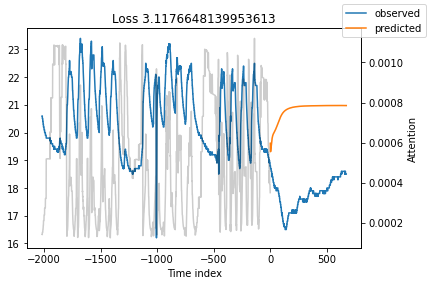

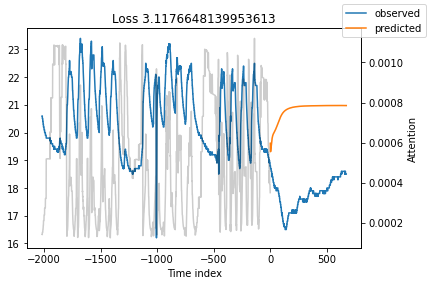

In [14]:
from sklearn.metrics import mean_squared_error

room1Model = TemporalFusionTransformer.load_from_checkpoint("lightning_logs/lightning_logs/version_13/checkpoints/epoch=16-step=850.ckpt")

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = room1Model.predict(val_dataloader)
print(mean_squared_error(actuals, predictions, squared=False))

raw_predictions, x = room1Model.predict(val_dataloader, mode="raw", return_x=True)
room1Model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)